In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
# split a loaded document into sentences
def to_pairs(doc):
 lines = doc.strip().split('\n')
 pairs = [line.split('\t') for line in  lines]
 return pairs

In [ ]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			#line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [ ]:
def save_clean_data(sentences, filename):
 dump(sentences, open(filename, 'wb'))
 print('Saved: %s' % filename)

In [ ]:
def load_clean_sentences(filename):
 return load(open(filename, 'rb'))

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

In [ ]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [ ]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [ ]:
# load dataset
filename = 'dataset.old.txt'

filename2 = 'dataset.new.txt'

with open('dataset.old.txt') as file1, open('dataset.new.txt') as file2, open('fulldata.txt', 'w') as outfile:
    for line1, line2 in zip(file1, file2):
        outfile.write(line1.strip() + '\t' + line2.strip() + '\n')
# split into ottoman-turkiye turkish pairs
filename = 'fulldata.txt'

doc = load_doc(filename)
pairs = to_pairs(doc)
# clean sentences
dataset_size = 1000; #dataset size
otto_turkish = clean_pairs(pairs)
otto_turkish = otto_turkish[:dataset_size]
# save clean pairs to file

save_clean_data(otto_turkish, 'ottoman-turkey-turkish.txt')
# spot check

raw_dataset = load_clean_sentences('ottoman-turkey-turkish.txt')
 
# reduce dataset size
n_sentences = dataset_size
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:900], dataset[900:] #9/10*datasize for traning,1/10 for testing
# save
save_clean_data(dataset, 'ottoman-turkey-turkish-both.pkl')
save_clean_data(train, 'ottoman-turkey-turkish-train.pkl')
save_clean_data(test, 'ottoman-turkey-turkish-test.pkl') 

# load datasets
dataset = load_clean_sentences('ottoman-turkey-turkish-both.pkl')
train = load_clean_sentences('ottoman-turkey-turkish-train.pkl')
test = load_clean_sentences('ottoman-turkey-turkish-test.pkl')


Saved: ottoman-turkey-turkish.txt
Saved: ottoman-turkey-turkish-both.pkl
Saved: ottoman-turkey-turkish-train.pkl
Saved: ottoman-turkey-turkish-test.pkl


In [ ]:
# prepare ottoman turkish tokenizer
ottoman_turkish_tokenizer = create_tokenizer(dataset[:, 0])
ottoman_turkish_vocab_size = len(ottoman_turkish_tokenizer.word_index) + 1
ottoman_turkish_length = max_length(dataset[:, 0])
print('Ottoman Turkish Vocabulary Size: %d' % ottoman_turkish_vocab_size)
print('Ottoman Turkish Max Length: %d' % (ottoman_turkish_length))
# prepare turkey turkish tokenizer
turkey_turkish_tokenizer = create_tokenizer(dataset[:, 1])
turkey_turkish_vocab_size = len(turkey_turkish_tokenizer.word_index) + 1
turkey_turkish_length = max_length(dataset[:, 1])
print('Türkiye Turkish Vocabulary Size: %d' % turkey_turkish_vocab_size)
print('Türkiye Turkish Max Length: %d' % (turkey_turkish_length))

Ottoman Turkish Vocabulary Size: 5066
Ottoman Turkish Max Length: 97
Türkiye Turkish Vocabulary Size: 5118
Türkiye Turkish Max Length: 94


In [ ]:
# prepare training data
trainX = encode_sequences(turkey_turkish_tokenizer, turkey_turkish_length, train[:, 1])
trainY = encode_sequences(ottoman_turkish_tokenizer, ottoman_turkish_length, train[:, 0])
trainY = encode_output(trainY, ottoman_turkish_vocab_size)
# prepare validation data
testX = encode_sequences(turkey_turkish_tokenizer, turkey_turkish_length, test[:, 1])
testY = encode_sequences(ottoman_turkish_tokenizer, ottoman_turkish_length, test[:, 0])
testY = encode_output(testY, ottoman_turkish_vocab_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 94, 256)           1310208   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 97, 256)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 97, 256)           525312    
                                                                 
 time_distributed (TimeDistr  (None, 97, 5066)         1301962   
 ibuted)                                                         
                                                                 
Total params: 3,662,794
Trainable params: 3,662,794
Non-

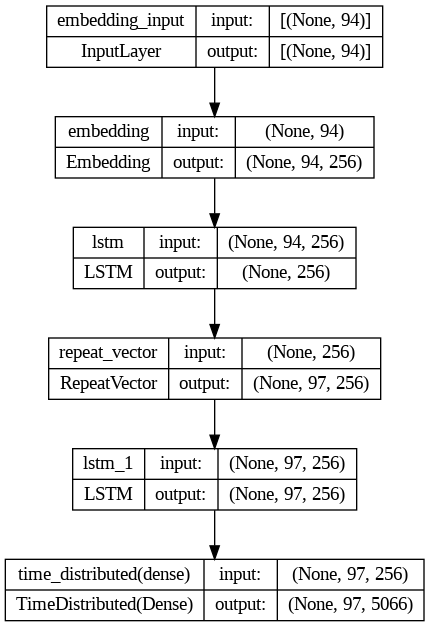

In [ ]:
# define model
model = define_model(turkey_turkish_vocab_size, ottoman_turkish_vocab_size, turkey_turkish_length, ottoman_turkish_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=5, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.98559, saving model to model.h5
15/15 - 53s - loss: 6.3979 - val_loss: 1.9856 - 53s/epoch - 4s/step
Epoch 2/5

Epoch 2: val_loss improved from 1.98559 to 1.68514, saving model to model.h5
15/15 - 44s - loss: 1.6040 - val_loss: 1.6851 - 44s/epoch - 3s/step
Epoch 3/5

Epoch 3: val_loss improved from 1.68514 to 1.52638, saving model to model.h5
15/15 - 44s - loss: 1.5436 - val_loss: 1.5264 - 44s/epoch - 3s/step
Epoch 4/5

Epoch 4: val_loss improved from 1.52638 to 1.37116, saving model to model.h5
15/15 - 44s - loss: 1.3366 - val_loss: 1.3712 - 44s/epoch - 3s/step
Epoch 5/5

Epoch 5: val_loss improved from 1.37116 to 1.34963, saving model to model.h5
15/15 - 44s - loss: 1.2890 - val_loss: 1.3496 - 44s/epoch - 3s/step


In [ ]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, ottoman_turkish_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# load datasets
dataset = load_clean_sentences('ottoman-turkey-turkish-both.pkl')
train = load_clean_sentences('ottoman-turkey-turkish-train.pkl')
test = load_clean_sentences('ottoman-turkey-turkish-test.pkl')
#prepare ottoman turkish tokenizer
ottoman_turkish_tokenizer = create_tokenizer(dataset[:, 0])
ottoman_turkish_vocab_size = len(ottoman_turkish_tokenizer.word_index) + 1
ottoman_turkish_length = max_length(dataset[:, 0])
# prepare turkiye turkish tokenizer
turkey_turkish_tokenizer = create_tokenizer(dataset[:, 1])
turkey_turkish_vocab_size = len(turkey_turkish_tokenizer.word_index) + 1
turkey_turkish_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(turkey_turkish_tokenizer, turkey_turkish_length, train[:, 1])
testX = encode_sequences(turkey_turkish_tokenizer, turkey_turkish_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, ottoman_turkish_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, ottoman_turkish_tokenizer, testX, test)

train
src=[trakyapasaeli derneginin basindakilerden bazilariyla daha istanbuldayken gorusmustum ], target=[trakyapasaeli cemiyetinin ruesasndan bazlarile daha istanbulda iken gorusmus idim ], predicted=[]
src=[k  o ], target=[k  o ], predicted=[]
src=[illerden delege getirilmesi icin o tarihten baslayarak benim erzuruma varisima kadar ve ondan sonra da  bu konuda olaganustu caba gosterdi ], target=[vilayetlerden murahhas celbi icin o tarihten itibaren  benim erzuruma muvasalatma kadar ve ondan sonra da  bu hususta fevkalade sarf gayret etti ], predicted=[]
src=[bu busbutun garibime gitmisti ], target=[bu busbutun istigrabm mucip olmustu ], predicted=[]
src=[birkac kez gelmesi icin emir vermistim ], target=[birkac defa gelmesi icin emir vermistim ], predicted=[]
src=[gibi hakli birtakim kuruntulara kapilmasi olmaz degildi ], target=[gibi bihakkn birtakm tevehhumata kaplmas mustebat degildi ], predicted=[]
src=[resit pasa   efendim birkac dakika daha dinlenmez misiniz  diye soze basladi 